In [1]:
import numpy as np
import klampt
import matplotlib.pyplot as plt
import cv2

%matplotlib inline

In [2]:
def load_image(path, threshold = int(255/2)):
    '''
    Loads an image using OpenCV, and converts it to a binary image.
    '''
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # convert to binary image (obstacle = 255, non-obstacle = 0)
    img = img > threshold
    #_, img = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return img

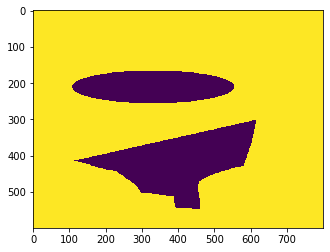

In [6]:
img = load_image("test_2.jpg")
plt.imshow(img)

In [7]:
def get_connected_components(column):
    """
    Given a column of the image, calculates the connected components of the column.
    """
    component_start_idx = 0
    rv = []
    inside_obstacle = False
    for i in range(1, len(column)):
        
        # We have just hit an obstacle. The connected component ends here
        if not inside_obstacle and not column[i] and column[i-1]:
            component = (component_start_idx, i)
            rv.append(component)
            inside_obstacle = True
        
        # We are not inside an obstacle anymore! Reset flag and the component_start_idx
        if inside_obstacle and column[i]:
            inside_obstacle = False
            component_start_idx = i
    rv.append((component_start_idx, len(column)))
    return rv


def calculate_connectivity_table(prev_cc, curr_cc):
    """
    Calculates the following table:
    rv[i, j] = True if prev_cc[i] and curr_cc[j] are connected
    otherwise rv[i, j] = False
    """
    rv = np.zeros((len(prev_cc), len(curr_cc)))
    for i in range(len(prev_cc)):
        prev = prev_cc[i]
        for j in range(len(curr_cc)):
            curr = curr_cc[j]
            
            if min(prev[1], curr[1]) > max(prev[0], curr[0]):
                rv[i, j] = True
            else:
                rv[i, j] = False
    return rv


def partition_image(image):
    H, W = image.shape
    partitioned_image = np.zeros(image.shape, dtype=int)
    
    prev_cc = None
    prev_component_values = None
    num_cells = 0
    
    # Sweep left to right
    for i in range(W):
        curr_col = image[:, i]
        
        # get the connected components of the column
        curr_cc = get_connected_components(curr_col)
        
        # first iteration, start a new component
        if i == 0:
            num_cells += 1
            curr_component_values = [num_cells for _ in range(len(curr_cc))]
        else:
            curr_component_values = [0 for _ in range(len(curr_cc))]
            connected = calculate_connectivity_table(prev_cc, curr_cc)
            
            for j in range(len(prev_cc)):
                # If the prev_cc[j] is connected to exactly one of the components in curr_cc,
                # just copy the previous component values over for that connected component
                if np.sum(connected[j, :]) == 1:
                    for k in range(len(curr_cc)):
                        if connected[j, k]:
                            curr_component_values[k] = prev_component_values[j]
                # prev_cc[j] is connected to multiple components in curr_cc.
                # That means this is an IN event (we have hit a polygon).
                elif np.sum(connected[j, :]) > 1:
                    for k in range(len(curr_cc)):
                        if connected[j, k]:
                            num_cells += 1
                            curr_component_values[k] = num_cells
                            
            for j in range(len(curr_cc)):
                # curr_cc[j] is connected to multiple components in prev_cc.
                # That means that this is an OUT event (we have just left a polygon).
                if np.sum(connected[:, j]) > 1:
                    num_cells += 1
                    curr_component_values[j] = num_cells
        
        
        # set the values for each component for the current column
        for j in range(len(curr_cc)):
            component = curr_cc[j]
            component_value = curr_component_values[j]
            partitioned_image[component[0] : component[1], i] = component_value
        
        prev_cc = curr_cc
        prev_component_values = curr_component_values
    return partitioned_image
        

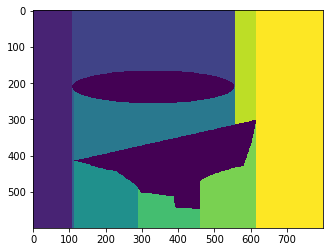

In [8]:
partitioned_img = partition_image(img)
plt.imshow(partitioned_img)